Bi-directional Reccurrent Neural Network(B-RNN)

In [35]:
import cv2
import numpy as np
import glob
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

In [36]:

gen_sign = (glob.glob('C:\\Users\\ASUS\\Downloads\\Dataset-20241007T134858Z-001\\Dataset\\dataset1\\real\\*.*')+glob.glob('C:\\Users\\ASUS\\Downloads\\Dataset-20241007T134858Z-001\\Dataset\\dataset2\\real\\*.*')+glob.glob('C:\\Users\\ASUS\\Downloads\\Dataset-20241007T134858Z-001\\Dataset\\dataset3\\real\\*.*')+glob.glob('C:\\Users\\ASUS\\Downloads\\Dataset-20241007T134858Z-001\\Dataset\\dataset4\\real\\*.*'))

forg_sign = (glob.glob('C:\\Users\\ASUS\\Downloads\\Dataset-20241007T134858Z-001\\Dataset\\dataset1\\forge\\*.*')+glob.glob('C:\\Users\\ASUS\\Downloads\\Dataset-20241007T134858Z-001\\Dataset\\dataset1\\forge\\*.*')+glob.glob('C:\\Users\\ASUS\\Downloads\\Dataset-20241007T134858Z-001\\Dataset\\dataset1\\forge\\*.*')+glob.glob('C:\\Users\\ASUS\\Downloads\\Dataset-20241007T134858Z-001\\Dataset\\dataset1\\forge\\*.*'))

In [37]:

train_ratio = 0.8
train_gen_sign = gen_sign[:int(len(gen_sign)*train_ratio)]
test_gen_sign = gen_sign[int(len(gen_sign)*train_ratio):]
train_forg_sign = forg_sign[:int(len(forg_sign)*train_ratio)]
test_forg_sign = forg_sign[int(len(forg_sign)*train_ratio):]

train_image_paths = train_gen_sign + train_forg_sign
test_image_paths = test_gen_sign + test_forg_sign

In [38]:

def img_to_patches(img, patch_size=(256,256)):
    patches = []
    for i in range(0, img.shape[0], patch_size[0]):
        for j in range(0, img.shape[1], patch_size[1]):
            patch = img[i:i+patch_size[0], j:j+patch_size[1]].flatten()
            patches.append(patch)
    return np.array(patches)

In [39]:

def preprocess_image(image_path, img_size=(256,256), patch_size=(256,256)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    img = cv2.resize(img, img_size)
    return img_to_patches(img, patch_size)

In [40]:

def process_images(image_paths, label):
    X_data = []
    y_data = []
    for image_path in image_paths:
        try:
            patches = preprocess_image(image_path)
            X_data.append(patches)
            y_data.append(label)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
    return np.array(X_data), np.array(y_data)

In [41]:

# Create training dataset
X_train_real, y_train_real = process_images(train_gen_sign, label=0)
X_train_forg, y_train_forg = process_images(train_forg_sign, label=1)

# Create test dataset
X_test_real, y_test_real = process_images(test_gen_sign, label=0)
X_test_forg, y_test_forg = process_images(test_forg_sign, label=1)

# Combine real and forged data
X_train = np.concatenate([X_train_real, X_train_forg], axis=0)
y_train = np.concatenate([y_train_real, y_train_forg], axis=0)

X_test = np.concatenate([X_test_real, X_test_forg], axis=0)
y_test = np.concatenate([y_test_real, y_test_forg], axis=0)

# Shuffle the training data
indices = np.random.permutation(len(X_train))
X_train = X_train[indices]
y_train = y_train[indices]

# Shuffle the test data
test_indices = np.random.permutation(len(X_test))
X_test = X_test[test_indices]
y_test = y_test[test_indices]

In [42]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (480, 1, 65536)
y_train shape: (480,)
X_test shape: (120, 1, 65536)
y_test shape: (120,)


In [43]:
# Reshape for LSTM input(batch_size, time_steps, input_dim)
timesteps = X_train.shape[1]
features = X_train.shape[2]

# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [44]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=False), input_shape=(timesteps, features)),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
# print model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 128)            │    33,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,596,098 (128.16 MB)

 Trainable params: 33,596,098 (128.16 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model.save('bi_run_signature_verification_model.h5')

In [47]:
# train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 568ms/step - accuracy: 0.5799 - loss: 0.6894 - val_accuracy: 0.6000 - val_loss: 0.6605
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 493ms/step - accuracy: 0.6097 - loss: 0.6680 - val_accuracy: 0.5833 - val_loss: 0.6544
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 492ms/step - accuracy: 0.6111 - loss: 0.6695 - val_accuracy: 0.6000 - val_loss: 0.6611
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 481ms/step - accuracy: 0.5697 - loss: 0.6894 - val_accuracy: 0.6000 - val_loss: 0.6471
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 482ms/step - accuracy: 0.6253 - loss: 0.6653 - val_accuracy: 0.5417 - val_loss: 0.6457
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 495ms/step - accuracy: 0.6257 - loss: 0.6763 - val_accuracy: 0.6000 - val_loss: 0.6422
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 487ms/step - accuracy: 0.5941 - loss: 0.6684 - val_accuracy: 0.6000 - val_loss: 0.6341
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 483ms/step - accuracy: 0.6018 - loss: 0.6635 - val_accuracy: 0

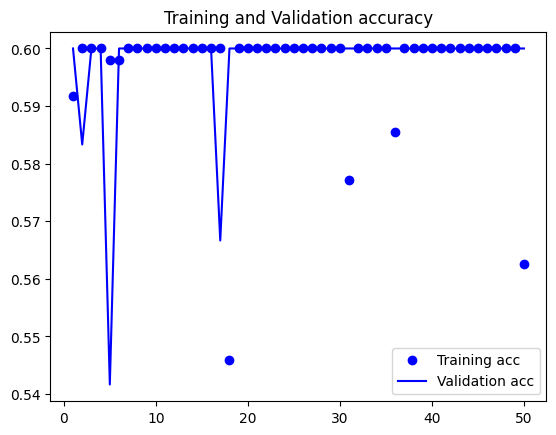

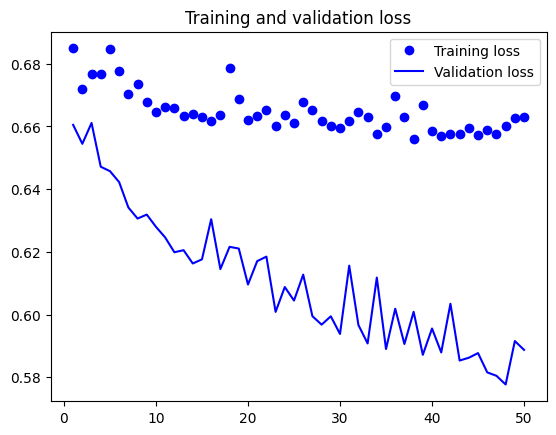

In [48]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [49]:
# Get the final loss and accuracy
final_loss, final_accuracy = model.evaluate(X_test, y_test)

# Print the results in percentage form
print("Final loss: {:.2f}%".format(final_loss * 100))
print("Final Accuracy: {:.2f}%".format(final_accuracy * 100))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5515 - loss: 0.6130
Final loss: 58.87%
Final Accuracy: 60.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


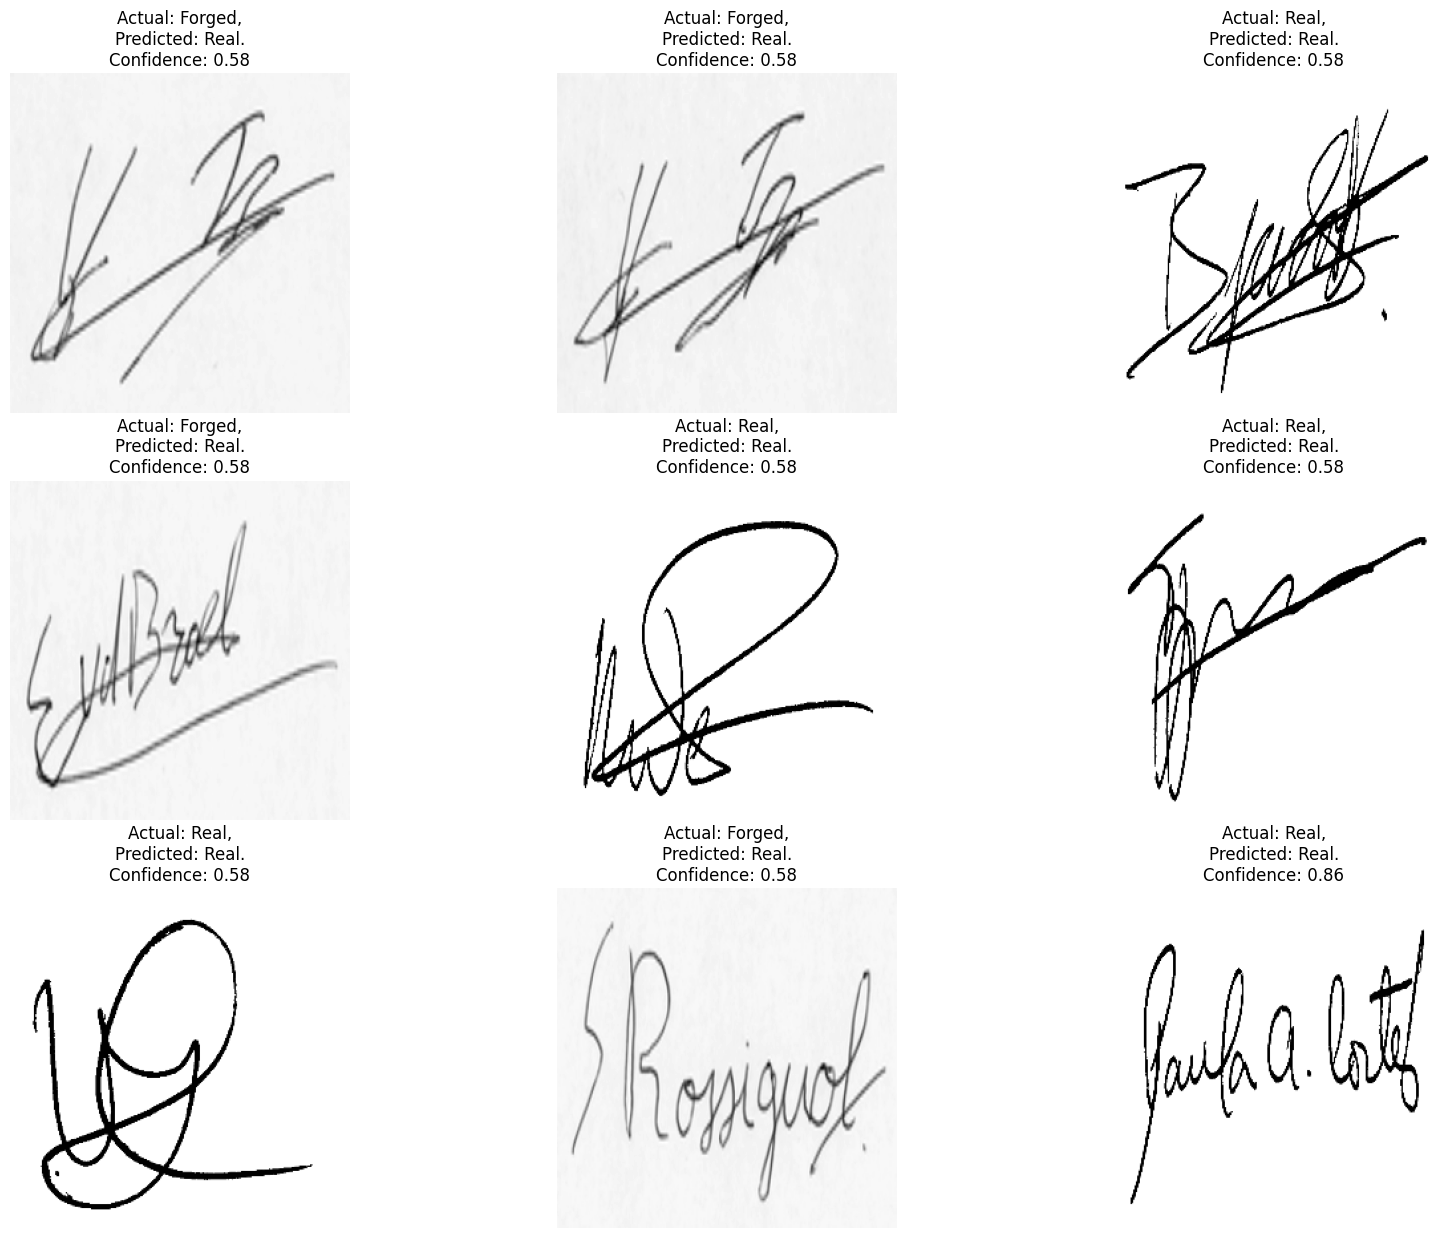

In [50]:
import matplotlib.pyplot as plt

# Assuming X_test is a numpy array and you want to visualize the first 9 images
plt.figure(figsize=(20, 15))

# Loop over the first 9 images and their labels
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image = X_test[i].reshape(256, 256)  # Reshape the patches back to the original image shape
    plt.imshow(image, cmap='gray')       # Display the image

    # Predict the class and confidence
    predicted_class = np.argmax(model.predict(np.expand_dims(X_test[i], axis=0)))  # Predict the class
    confidence = np.max(model.predict(np.expand_dims(X_test[i], axis=0)))          # Get the confidence score

    actual_class = np.argmax(y_test[i])  # Get the actual class from y_test

    class_names = ['Real', 'Forged']     # Class names
    plt.title(f'Actual: {class_names[actual_class]},\nPredicted: {class_names[predicted_class]}.\nConfidence: {confidence:.2f}')
    plt.axis('off')
plt.show()